## Initialization

In [174]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import os

import pyro
from torch.distributions import constraints
from torch.nn import Parameter
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method
import pyro.contrib.gp as gp
from pyro.infer import Predictive
from sklearn.utils import shuffle
# fix random generator seed (for reproducibility of results)
np.random.seed(123456789)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data

In [175]:
# Function for loading data
def get_data(hierar = False, oneHot = False):
    """
    Loads and prepares our data

    Input:
    hierar: saves seperatly the column we wanna do groupings over in the hierarchical model
    onehot: one-hot-encodes data 

    Output: 
    X_train: Training data
    y_train: Training target
    X_test: test data
    y_test: test target
    age: list of size two with training and test data for grouping data
    names: list of all names of features 
    
    """
    #Gets path to folder
    path = os.getcwd()
    train_path = path + '/train_heart.csv'
    test_path = path + '/test_heart.csv'

    #variable for the categorical data columns in the dataset
    col = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
    
    # Load Data
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    if hierar:
        sex_train = df_train['sex']
        sex_test= df_test['sex']
        sex = [sex_train, sex_test ]
    else: 
        sex = []

    if oneHot:
        # One hot encode data: 
        X_train = pd.get_dummies(df_train,columns=col)
        X_test = pd.get_dummies(df_test,columns=col)
        
        #Extract y values:
        y_train = X_train['target'].values.astype("int")
        y_test = X_test['target'].values.astype("int")

        #extracts names of each column
        names = list(X_train.drop("target", axis='columns').columns)

        #Extract data 
        X_train = X_train.loc[:, X_train.columns != 'target'].values
        X_test = X_test.loc[:, X_test.columns != 'target'].values

        #Normalize non one-hot-encoded data (training data)
        X_train_temp = X_train[:,0:5].astype('float')
        X_mean = X_train_temp.mean(axis=0)
        X_std = X_train_temp.std(axis=0)
        X_train_temp = (X_train_temp - X_mean) / X_std
        X_train[:,0:5] = X_train_temp

        #Normalize non one-hot-encoded data (training data)
        X_train_temp = X_test[:,0:5].astype('float')
        X_mean = X_train_temp.mean(axis=0)
        X_std = X_train_temp.std(axis=0)
        X_train_temp = (X_train_temp - X_mean) / X_std
        X_test[:,0:5] = X_train_temp
    else:
        X_train = df_train
        X_test = df_test

        #Extract y values:
        y_train = X_train['target'].values.astype("int")
        y_test = X_test['target'].values.astype("int")
        
        #extracts names of each column
        names = list(X_train.drop("target", axis='columns').columns)

        #Extract data 
        X_train = X_train.loc[:, X_train.columns != 'target'].values
        X_test = X_test.loc[:, X_test.columns != 'target'].values

        #Normalize non one-hot-encoded data (training data)
        X_train_temp = X_train.astype('float')
        X_mean = X_train_temp.mean(axis=0)
        X_std = X_train_temp.std(axis=0)
        X_train_temp = (X_train_temp - X_mean) / X_std
        X_train = X_train_temp

        #Normalize non one-hot-encoded data (training data)
        X_train_temp = X_test.astype('float')
        X_mean = X_train_temp.mean(axis=0)
        X_std = X_train_temp.std(axis=0)
        X_train_temp = (X_train_temp - X_mean) / X_std
        X_test = X_train_temp
  

    return [X_train,y_train,X_test,y_test,sex,names]


# Read the CSV file into a pandas DataFrame and display the first few rows
X_train,y_train,X_test,y_test,age,sdf = get_data(True,True)

#Transform trainign and test data to tensor form.
X_train_tensor = torch.tensor(X_train.astype('float')).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test.astype('float')).float()
y_test_tensor = torch.tensor(y_test).float()

#define train and test grouping data
ind_train = age[0].astype("int")
ind_test = age[1].astype("int")

#turn into tensor form
ind_train = torch.tensor(ind_train) # these are indices, therefore they need to be (long) integers
ind_test = torch.tensor(ind_test) # these are indices, therefore they need to be (long) integers

# global training step number
steps = 2000


## Binary Logistic Regression

In [176]:
#____________________________binary logistic regression model___________________________

def BinaryLogisticRegression(X, n_cat, obs=None):
    #get number of features
    input_dim = X.shape[1]

    #intercept 
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept

    #Weights
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [177]:
#____________________________Training model___________________________

#Number of classes
n_cat = 2

# Define guide function
guide = AutoMultivariateNormal(BinaryLogisticRegression)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = steps

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(BinaryLogisticRegression, guide, optimizer, loss=elbo)

#initialize list for elbo values
elbo_binlogreg = []

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, n_cat, y_train_tensor)
    elbo_binlogreg.append(elbo)

In [178]:
#____________________________Predictions and Accuracy___________________________

#Set up prediction distribution
predictive = Predictive(BinaryLogisticRegression, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))

#Sample from prediction distribution
samples = predictive(X_train_tensor, n_cat, y_train_tensor-1)

#Extract samples
samples_alpha = samples["alpha"].detach().squeeze()
samples_beta = samples['beta'].detach().squeeze()

#Find mean of alpha and beta
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

#use extracted alpha and beta to make predictions for test dataset
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1

# evaluate prediction accuracy
acc_bin = 1.0*np.sum((y_hat-1) == y_test) / len(y_test)
print("Accuracy:", acc_bin)

Accuracy: 0.8778877887788779


In [179]:
#_____________________ Beta Values _______________________
beta_BLR_0 = beta_hat[5:7,0][0]
beta_BLR_1 = beta_hat[5:7,0][1]
print('Beta Values: ', beta_BLR_0, beta_BLR_1)

Beta Values:  -0.63529134 0.5169336


## Hierarchical Model

In [180]:
#____________________________Hierarchical and hierarchical+ARD model___________________________

def hierarchical_model(X, ind, n_cat, n_ind, hyp_param, obs=None):
    # define number of observations and features
    n_obs, n_features = X.shape
    
    # Hyperpriors for the intercept alpha
    mu = pyro.sample("alpha_mu", dist.Normal(0., hyp_param[2]).expand([n_cat]).to_event(1))
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(hyp_param[3]).expand([n_cat]).to_event(1))
    
    # sex-specific alpha and beta
    with pyro.plate("individuals", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event(1))  # Shape: [n_ind, n_cat]
        beta = pyro.sample("beta", dist.Normal(torch.zeros(n_features, n_cat), 1).to_event(2))  # Shape: [n_ind, n_features, n_cat]

    # Observation model
    with pyro.plate("data", n_obs):
        # Use the sex-specific alpha and beta values
        alpha_obs = alpha[ind]
        beta_obs = beta[ind]
        val = alpha_obs + torch.einsum('ij,ijk->ik', X, beta_obs)
        
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)

def hierarchical_model_ARD(X, ind, n_cat, n_ind, hyp_param, obs=None):
    # define number of observations and features
    n_obs, n_features = X.shape
    
    # Hyperprior for the variance of beta
    a = pyro.sample("a", dist.Gamma(hyp_param[0]*torch.ones(n_features, 1), hyp_param[1]*torch.ones(n_features, 1)).to_event())
    
    # Hyperpriors for the hierarchical intercept alpha
    mu = pyro.sample("alpha_mu", dist.Normal(0., hyp_param[2]).expand([n_cat]).to_event(1))
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(hyp_param[3]).expand([n_cat]).to_event(1))
    
    # Hierarchical prior for sex-specific alpha and beta
    with pyro.plate("individuals", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event(1))  # Shape: [n_ind, n_cat]
        beta = pyro.sample("beta", dist.Normal(torch.zeros(n_features, n_cat), a).to_event(2))  # Shape: [n_ind, n_features, n_cat]

    # Observation model
    with pyro.plate("data", n_obs):
        # Use the sex-specific alpha and beta values
        alpha_obs = alpha[ind]
        beta_obs = beta[ind]
        val = alpha_obs + torch.einsum('ij,ijk->ik', X, beta_obs)
        
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)

In [181]:
#____________________________Training Hierarchical model___________________________

# Prepare data for Pyro model
n_cat = int(y_train.max())
#print('n_cat', n_cat)
n_ind = ind_train.max()

#define model
model = hierarchical_model

# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = steps

# define hyperparameters
hyp_param = [1,1,1,1]

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# List to store ELBO values
elbo_Hirach = []

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, ind_train, n_cat+1, n_ind+1, hyp_param, y_train_tensor)
    elbo_Hirach.append(elbo)  # Store ELBO value

In [182]:
#____________________________Accuracy Hierarchical model___________________________

#Set up predictive distribution
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train_tensor, ind_train, n_cat+1, n_ind+1, hyp_param, y_train_tensor)

#Extract samples 
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()

# Compute the expected values of the parameters
alpha_hat = alpha_samples.mean(axis=0)  # Shape: [n_ind, n_cat]
beta_hat = beta_samples.mean(axis=0)  # Shape: [n_features, n_cat]

#get shape of test data
n,p = X_test.shape

#initialize empty vector for predictions
y_hat = np.zeros((n,2))

#loop over each observation in the test dtaset
for i in range(n):
    #if-statement for using the correct beta /alpha parameters corresponding to the sex.
    if ind_test[i] == 0:
        y_hat[i,:] = alpha_hat[0,:] + np.dot(X_test[i,:], beta_hat[0,:,:])
    else:
        y_hat[i,:] = alpha_hat[1,:] + np.dot(X_test[i,:], beta_hat[1,:,:])

y_hat = np.argmax(y_hat, axis=1)

acc_hierach = 1.0*np.sum(y_hat == y_test) / len(y_test)
print("Accuracy:", acc_hierach)

Accuracy: 0.8745874587458746


In [183]:
#_____________________ Beta Values _______________________

beta_hir_0_0 = beta_hat[0,5:7,0][0]
beta_hir_0_1 = beta_hat[0,5:7,0][1]

beta_hir_1_0 = beta_hat[1,5:7,0][0]
beta_hir_1_1 = beta_hat[1,5:7,0][1]

print('Beta Values 0: ', beta_hat[0,5:7,0])
print('Beta Values 1: ', beta_hat[1,5:7,0])

Beta Values 0:  [0.1007398 0.1565258]
Beta Values 1:  [-0.02988737 -0.0668631 ]


In [184]:
#____________________________Training Hierarchical+ARD model___________________________

# Prepare data for Pyro model
n_cat = int(y_train.max())
#print('n_cat', n_cat)
n_ind = ind_train.max()

model = hierarchical_model_ARD

# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = steps

hyp_param = [1,1,1,1]

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# List to store ELBO values
elbo_HirachARD = []

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, ind_train, n_cat+1, n_ind+1, hyp_param, y_train_tensor)
    elbo_HirachARD.append(elbo)  # Store ELBO value

In [185]:
#____________________________Accuracy Hierarchical+ARD model___________________________
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train_tensor, ind_train, n_cat+1, n_ind+1, hyp_param, y_train_tensor)

beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()

# Compute the expected values of the parameters
alpha_hat = alpha_samples.mean(axis=0)  # Shape: [n_ind, n_cat]
beta_hat = beta_samples.mean(axis=0)  # Shape: [n_features, n_cat]

n,p = X_test.shape

#initialize empty vector for predictions
y_hat = np.zeros((n,2))

#loop over each observation in the test dtaset
for i in range(n):
    #if-statement for using the correct beta /alpha parameters corresponding to the sex.
    if ind_test[i] == 0:
        y_hat[i,:] = alpha_hat[0,:] + np.dot(X_test[i,:], beta_hat[0,:,:])
    else:
        y_hat[i,:] = alpha_hat[1,:] + np.dot(X_test[i,:], beta_hat[1,:,:])

y_hat = np.argmax(y_hat, axis=1)
acc_hierachARD = 1.0*np.sum(y_hat == y_test) / len(y_test)
print("Accuracy:", acc_hierachARD)

Accuracy: 0.8811881188118812


In [186]:
beta_hirA_0_0 = beta_hat[0,5:7,0][0]
beta_hirA_0_1 = beta_hat[0,5:7,0][1]

beta_hirA_1_0 = beta_hat[1,5:7,0][0]
beta_hirA_1_1 = beta_hat[1,5:7,0][1]

print('Beta Values 0: ', beta_hat[0,5:7,0])
print('Beta Values 1: ', beta_hat[1,5:7,0])


Beta Values 0:  [-0.02292711 -0.01984177]
Beta Values 1:  [-0.04829321  0.001784  ]


## Gaussian Processes

In [187]:
#____________________________Train Gaussian process___________________________

# reset parameters
pyro.clear_param_store()

# initialize the kernel, likelihood, and model
kernel = gp.kernels.Matern32(input_dim=30, lengthscale=torch.ones(30)) 
likelihood = gp.likelihoods.Binary()

#define model using a pyro model for variational gaussian process
model = gp.models.VariationalGP(
    X_train_tensor,
    y_train_tensor,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([]),
)

# use the built-in support provided by the GP module to train
num_steps = steps
losses_gp = gp.util.train(model, num_steps=num_steps)

In [188]:
#____________________________Prediction for GP___________________________

# initialize list for prediction accuracies
acc = []
for i in range(100):

    #shuffle data
    X_shuf,y_shuf = shuffle(X_test_tensor,y_test_tensor)
    
    #Use model to find mean, var and linear part
    mean, var = model(X_shuf)
    
    #find predictions
    y_hat = model.likelihood(mean, var)

    #compute accuracy and save to list
    pred = (y_hat==y_shuf).sum()*1/(len(y_shuf))
    acc.append(pred)

acc_GP = np.mean(acc)
#print accuracy
print(f"Accuracy: {acc_GP :0.2f}%")

Accuracy: 0.98%


## Gaussian Process + Linear model

In [189]:
#Class for doing a Gaussian process combined with a linear model.
# the majority of this class is taken from the clas swe used for the normal Gaussian process above.


class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations 
    :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where 
    :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating 
    :math:`q(f)` to the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.

    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. 
        Size of variational parameters is :math:`\mathcal{O}(N^2)`.

    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.

    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.

    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.

    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.

    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.

    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.

    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
        
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        #split up data for a linear part and a GP part
        X_nn_1 = X[:,0:5]
        X_nn_2 = X[:,7:]
        self.X_GP = torch.tensor(np.hstack([X_nn_1,X_nn_2]))
        self.X_linear = torch.tensor(X[:,5:7])
        
        #___________________________GP part____________________________________________
        #Define likelihood
        self.likelihood = likelihood

        # define batch shape and latent space shape
        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        
        # number of features
        N = self.X_GP.size(0) # N = shape(1025)

        #vector of size N with random numbers from -1,1
        f_loc_init = torch.tensor(np.random.uniform(low=-1, high=1, size=(N)))

        # change to float
        f_loc_init = f_loc_init.to(torch.float)

        #initialize mean vector to be learned
        f_loc = self.X_GP.new_ones(self.latent_shape + (N,))
        
        #set mean vector as parameter
        self.f_loc = Parameter(f_loc)
        
        #initialize identity matrix of size: (1025, 1025)
        identity = eye_like(self.X_GP, N)

        #initialize var vector to be learned 
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))

        # set var param as parameter
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

        #___________________________Lin part____________________________________________
        #initialize vector for beta parameters
        f_bin = self.X_linear.new_zeros(self.latent_shape + (2,))
        #save as parameter
        self.f_bin = Parameter(f_bin)
        

    @pyro_method
    def model(self):
        self.set_mode("model")
        
        N = self.X_GP.size(0)
        Kff = self.kernel(self.X_GP).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()
        
        
        #initialize 
        f_loc_init = torch.tensor(np.random.uniform(low=-1, high=1, size=(N)))
        
        f_loc_init = f_loc_init.to(torch.float)
        zero_loc = self.X_GP.new_zeros(self.f_loc.shape)
        
        if self.whiten:

            identity = eye_like(self.X_GP, N) #

            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            
            f_scale_tril = Lff.matmul(self.f_scale_tril)

            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X_GP)
        f_var = f_scale_tril.pow(2).sum(dim=-1)


        zero_loc_bin = self.X_linear.new_zeros(self.f_bin.shape)
        pyro.sample(self._pyro_get_fullname("beta"), dist.Normal(zero_loc_bin, 0.1*torch.ones(2)).to_event())
        f_bin = self.f_bin

        lin_out = self.X_linear@f_bin
        
        if self.y is None:
            return f_loc, f_var
        else:
            
            res = self.likelihood(f_loc+lin_out, f_var, self.y)
            
            return res

    @pyro_method
    def guide(self):

        self.set_mode("guide")

        self._load_pyro_samples()
        
        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))
        
        pyro.sample(self._pyro_get_fullname("beta"), dist.Normal(self.f_bin, 0.1*torch.ones(2)).to_event())

    def forward(self, Xnew, full_cov=False):
        X_nn_1 = Xnew[:,0:5]
        X_nn_2 = Xnew[:,7:]
        X_GP = torch.tensor(np.hstack([X_nn_1,X_nn_2]))
        X_linear = Xnew[:,5:7]
        
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).

        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
            
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.

        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
            
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        
        self.set_mode("guide")

        loc, cov = conditional(X_GP, self.X_GP, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        
        linear_out = X_linear@self.f_bin

        return loc + self.mean_function(X_GP), cov, linear_out

In [190]:
#reset pyro parameters
pyro.clear_param_store()

# initialize the kernel, likelihood, and model
p,n = X_train.shape
kernel = gp.kernels.Matern32(input_dim=n-2, lengthscale=torch.ones(n-2)) # 99.01% accuracy
likelihood = gp.likelihoods.Binary()

#define model. 
model = VariationalGP(
    X_train_tensor,
    y_train_tensor,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([]),
)

# use the built-in support provided by the GP module to train
num_steps = steps
losses_gpLin = gp.util.train(model, num_steps=num_steps)

/var/folders/rl/2d6x2yy927z8k4n7s2v1ng3m0000gn/T/ipykernel_16671/352339620.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_linear = torch.tensor(X[:,5:7])


In [191]:
# initialize list for prediction accuracies
acc = []

for i in range(3):

    #shuffle data 
    X_shuf,y_shuf = shuffle(X_test_tensor,y_test_tensor)

    #Use model to find mean, var and linear part
    mean, var, linout = model(X_shuf)

    #throw it through model likelihood to get prediction
    y_hat = model.likelihood(mean+linout, var)
    
    #save accuracy to list
    acc.append((y_hat==y_shuf).sum()*1/(len(y_shuf)))

acc_GPLin = np.mean(acc)
#print accuracy
print(f"Accuracy: {acc_GPLin :0.2f}%")

Accuracy: 0.98%


In [192]:

beta_GP_0 = model.f_bin.detach().numpy()[0]
beta_GP_1 = model.f_bin.detach().numpy()[1]

print('Beta Values: ', model.f_bin.detach().numpy())

Beta Values:  [ 0.01049113 -0.02489775]


## Neural Networks

In [193]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        prediction_mean = X.squeeze(-1)

        """
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Categorical(logits=alpha + X.matmul(beta)), obs=y)
        """

        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Bernoulli(logits=prediction_mean), obs=y)
            
        return y

class FFNN_Lin(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN_Lin, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X_nn_1 = X[:,0:5]
        X_nn_2 = X[:,7:]
        X_nn = torch.tensor(np.hstack([X_nn_1,X_nn_2]))
        
        X_nn = self.tanh(self.in_layer(X_nn))
        X_nn = self.tanh(self.h_layer(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)
        #print('nn_out: ', nn_out.shape)


        beta_lin = pyro.sample("beta", dist.Normal(torch.zeros(2), 0.1*torch.ones(2)).to_event())
        #print('beta par: ', beta_lin)
        X_linear = X[:,5:7]
        #print('Lin: ', X_linear.shape)

        with pyro.plate("observations"):
            linear_out = X_linear@beta_lin
            #print('Lin out: ', linear_out.shape)
            y = pyro.sample("obs", dist.Normal(nn_out+linear_out, 0.1), obs=y)
            
        return y


In [194]:
# Define guide function
pyro.clear_param_store()
model = FFNN(n_in=X_train_tensor.shape[1], n_hidden=5, n_out=1)
guide = AutoDiagonalNormal(model)

# Define the number of optimization steps
n_steps = steps

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

elbo_nn = []
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    elbo_nn.append(elbo)

In [195]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("obs", "_RETURN"))

acc = []

for i in range(10):

    #shuffle data 
    X_shuf,y_shuf = shuffle(X_test_tensor,y_test_tensor)
    samples = predictive(X_shuf)

    samples = samples['obs'].detach().squeeze()
    y_hat = np.round(samples.mean(axis=0).numpy())
    
    pred = 1.0*np.sum((y_hat) == y_shuf.numpy()) / len(y_shuf)
    acc.append(pred)

acc_nn = np.mean(acc)

print("Accuracy:", acc_nn)

Accuracy: 0.9689768976897689


In [196]:
# Define guide function
model = FFNN_Lin(n_in=X_train_tensor.shape[1]-2, n_hidden=4, n_out=1) 
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = steps

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

elbo_nnLin = []

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    elbo_nnLin.append(elbo)
    

In [203]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("obs","beta", "_RETURN"))
samples = predictive(X_test_tensor)
beta_sam = samples["beta"].detach().numpy()

acc = []
for i in range(10):

    #shuffle data 
    X_shuf,y_shuf = shuffle(X_test_tensor,y_test_tensor)
    samples = predictive(X_shuf)

    samples = samples['obs'].detach().squeeze()
    y_hat = np.round(samples.mean(axis=0).numpy())
    
    pred = 1.0*np.sum((y_hat) == y_shuf.numpy()) / len(y_shuf)
    acc.append(pred)

acc_nnLin = np.mean(acc)
print("Accuracy:", acc_nnLin)

Accuracy: 0.9801980198019802


In [204]:
beta_nn_0 = np.mean(beta_sam,axis=0)[0][0]
beta_nn_1 = np.mean(beta_sam,axis=0)[0][1]

print('beta values: ',np.mean(beta_sam,axis=0)[0])

beta values:  [ 0.03239252 -0.01219704]


## Plot ELBO results

                                 Accuracy             Beta_0             beta_1
___________________________________________________________________________________
BinLogReg                 :       87.79               -0.64               0.52
Hierarchical              :       87.46            0.1   0.16        -0.03   -0.07
Hierarchical+ARD          :       88.12            -0.02   -0.02        -0.05   0.0
GaussProcess              :       98.37
GaussProcess+Lin          :       98.35                0.01               -0.02
Neural Network            :       96.9
Neural Network + Lin      :       98.02               0.03               -0.01
___________________________________________________________________________________


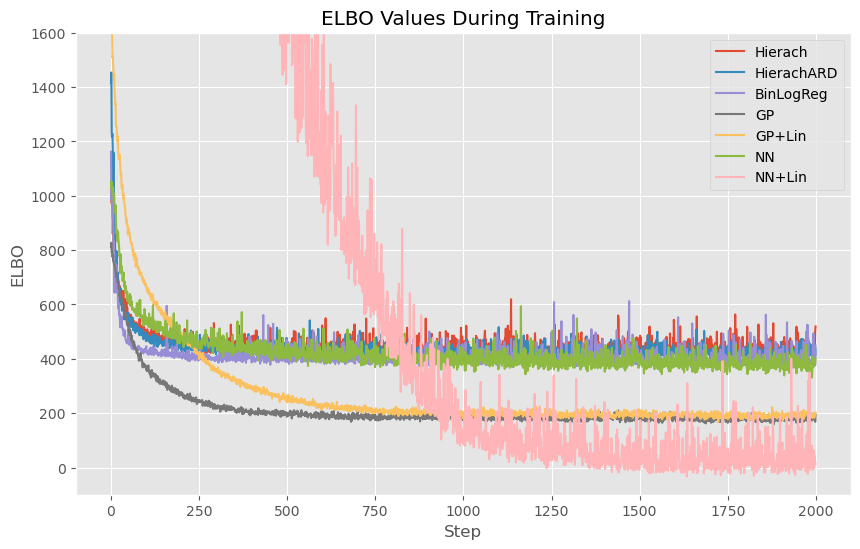

In [207]:
accuracy = [acc_bin, acc_hierach, acc_hierachARD, acc_GP, acc_GPLin, acc_nn, acc_nnLin]
names = ['BinLogReg           ', 'Hierarchical        ', 'Hierarchical+ARD    ', 'GaussProcess        ', 'GaussProcess+Lin    ', 'Neural Network      ', 'Neural Network + Lin']

beta0 = [beta_BLR_0, beta_hir_0_0, beta_hir_0_1,beta_hirA_0_0, beta_hirA_0_1,beta_GP_0, beta_nn_0]
beta1 = [beta_BLR_1, beta_hir_1_0, beta_hir_1_1,beta_hirA_1_0, beta_hirA_1_1,beta_GP_1, beta_nn_1]

print('                                 Accuracy             Beta_0             beta_1')
print('___________________________________________________________________________________')
for i in range(len(names)):
    if names[i] == 'Hierarchical        ':
        print(names[i],'     :      ',np.round(100*accuracy[i],2),'          ',np.round(beta0[i],2),' ',np.round(beta0[i+1],2),'      ',np.round(beta1[i],2),' ',np.round(beta1[i+1],2))
    
    elif names[i] == 'Hierarchical+ARD    ':
        print(names[i],'     :      ',np.round(100*accuracy[i],2),'          ',np.round(beta0[i+1],2),' ',np.round(beta0[i+2],2),'      ',np.round(beta1[i+1],2),' ',np.round(beta1[i+2],2))
    
    elif names[i] == 'GaussProcess        ':
        print(names[i],'     :      ',np.round(100*accuracy[i],2))
    
    elif names[i] == 'Neural Network      ':
        print(names[i],'     :      ',np.round(100*accuracy[i],2))
    
    elif names[i] =='GaussProcess+Lin    ':
        print(names[i],'     :      ',np.round(100*accuracy[i],2),'              ',np.round(beta0[i+1],2),'             ',np.round(beta1[i+1],2))
              
    else:
        print(names[i],'     :      ',np.round(100*accuracy[i],2),'             ',np.round(beta0[i],2),'             ',np.round(beta1[i],2))
print('___________________________________________________________________________________')

plt.figure(figsize=(10, 6))
plt.plot(elbo_Hirach, label='Hierach')
plt.plot(elbo_HirachARD, label='HierachARD')
plt.plot(elbo_binlogreg, label='BinLogReg')
plt.plot(losses_gp, label='GP')
plt.plot(losses_gpLin, label='GP+Lin')
plt.plot(elbo_nn, label='NN')
plt.plot(elbo_nnLin, label='NN+Lin')
plt.ylim([-100,1600])
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO Values During Training')
plt.legend()
plt.show()